# Starbucks Capstone Challenge - Data Wrangling

## Introduction

We'll try to transform the json into observable table. We'll maintain all 3 table, but simplify it as much as possible. At this stage, we're also going to perform basic cleaning for missing data and outliers.

## Setup

In [1]:
import sys

!{sys.executable} -m pip install -e ../ --quiet

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pandas.api.types import CategoricalDtype
from sb_capstone.wrangling import tukey_rule

%matplotlib inline

## Inspect Data

**Portfolio**

In [3]:
portfolio = pd.read_json('../data/raw/portfolio.json', orient='records', lines=True)
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [5]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


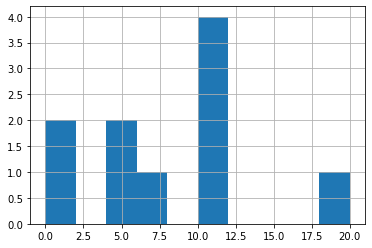

In [6]:
portfolio.difficulty.hist();

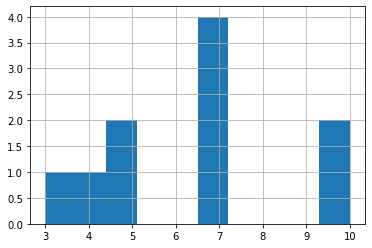

In [7]:
portfolio.duration.hist();

In [8]:
portfolio.channels.explode().value_counts()

email     10
mobile     9
web        8
social     6
Name: channels, dtype: int64

In [9]:
portfolio.offer_type.value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [10]:
portfolio.id.duplicated().sum()

0

**NOTES**

* A glaring issue we can see is that offer_id is in `guid` format. This will be confusing in the long run. It's much easier to analyze later if we convert this to `int`.

### Profile

In [11]:
profile = pd.read_json('../data/raw/profile.json', orient='records', lines=True)
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [12]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [13]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [14]:
profile.id.duplicated().sum()

0

In [15]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [16]:
profile[profile.gender.isnull()]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


In [17]:
profile[profile.gender.isnull()].age.value_counts()

118    2175
Name: age, dtype: int64

In [18]:
profile[profile.gender.isnull()].describe()

,age,became_member_on,income
count,2175.0,2.175000e+03,0.0
mean,118.0,2.016804e+07,NaN
std,0.0,1.009105e+04,NaN
min,118.0,2.013080e+07,NaN
25%,118.0,2.016070e+07,NaN
50%,118.0,2.017073e+07,NaN
75%,118.0,2.017123e+07,NaN
max,118.0,2.018073e+07,NaN


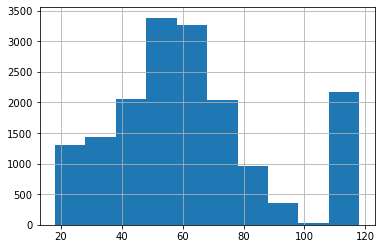

In [19]:
profile.age.hist();

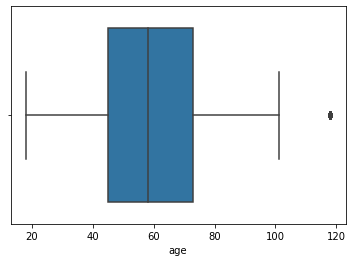

In [20]:
sns.boxplot(x=profile.age);

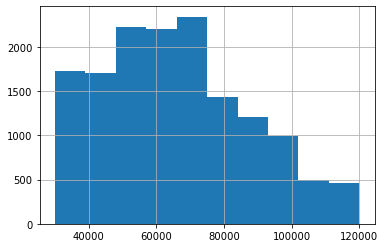

In [21]:
profile.income.hist();

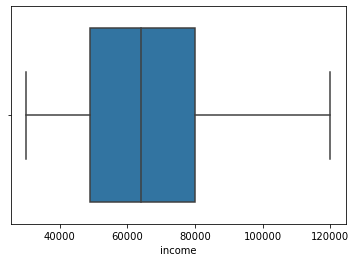

In [22]:
sns.boxplot(x=profile.income);

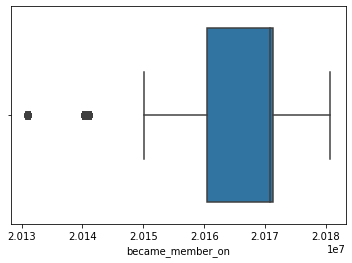

In [23]:
sns.boxplot(x=profile.became_member_on);

**NOTES**

* It'll easier later if we convert `became_member_on` to date format. With this we can easily extract day, month, year.
* `age` when `gender` is `null`, income is also `null`, while `age` is always 118. This maybe because the minimum date is set to `1900`. Convert `118` to `NaN`. For now, it's hard to assess if these `null` values are safe to delete. We'll leave it as is.
* To be consistent as well, `person_id` is also in `guid`. It's much easier to observe them if we convert to `int`.
* There are some outliers in `became_member_on`, however, this may not matter for now.

### Transcript

In [24]:
transcript = pd.read_json('../data/raw/transcript.json', orient='records', lines=True)
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [25]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [26]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [27]:
transcript[transcript.event == "transaction"].value.head()

12654    {'amount': 0.8300000000000001}
12657                 {'amount': 34.56}
12659                 {'amount': 13.23}
12670                 {'amount': 19.51}
12671                 {'amount': 18.97}
Name: value, dtype: object

In [28]:
transcript[transcript.event == "offer received"].value.head()

0    {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2    {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3    {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
Name: value, dtype: object

In [29]:
transcript[transcript.event == "offer viewed"].value.head()

12650    {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651    {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653    {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655    {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
Name: value, dtype: object

In [30]:
transcript[transcript.event == "offer completed"].value.head()

12658    {'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672    {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679    {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692    {'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697    {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...
Name: value, dtype: object

**NOTES**

* For consistency, we'll rename person to `person_id`.
* In line with previous conversion, we're going to map `person_id` to `int` and `offer_id` to `int`.
* Convert `event` to snake case for easier access in `pandas`.
* Convert `value` to columns.

## Transform

### Portfolio

In [31]:
# Convert `id` to `int`

portfolio = portfolio.rename(columns={'id': 'hash_id'})
portfolio["id"] = portfolio.apply(lambda x: x.index + 1).hash_id

portfolio.head()


,reward,channels,difficulty,duration,offer_type,hash_id,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,2
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,3
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,4
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,5


In [32]:
# reorder columns (retain hash_id for now)
portfolio = portfolio[["id", "offer_type", "channels", "reward", "difficulty", "duration", "hash_id"]]
portfolio.head()

,id,offer_type,channels,reward,difficulty,duration,hash_id
0,1,bogo,"[email, mobile, social]",10,10,7,ae264e3637204a6fb9bb56bc8210ddfd
1,2,bogo,"[web, email, mobile, social]",10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0
2,3,informational,"[web, email, mobile]",0,0,4,3f207df678b143eea3cee63160fa8bed
3,4,bogo,"[web, email, mobile]",5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,discount,"[web, email]",5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7


### Profile

In [33]:
# `became_member_on` to `datetime`

profile.became_member_on = profile.became_member_on.astype(str).apply(lambda x: pd.to_datetime(x, format='%Y%m%d'))
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [34]:
# convert `age` 118 to `NaN`

profile.loc[profile.age == 118, 'age'] = np.nan
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               14825 non-null  float64       
 2   id                17000 non-null  object        
 3   became_member_on  17000 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 664.2+ KB


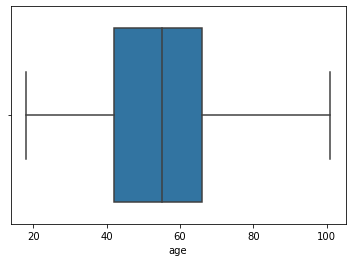

In [35]:
sns.boxplot(x=profile.age);

In [36]:
# convert `id` to `int`

profile = profile.rename(columns={'id': 'hash_id'})
profile["id"] = profile.apply(lambda x: x.index + 1).hash_id
profile.head()

,gender,age,hash_id,became_member_on,income,id
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,1
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,3
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,4
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,5


In [37]:
# reorder columns (retain hash_id for now)

profile = profile[["id", "gender", "age", "income", "became_member_on", "hash_id"]]
profile.head()

,id,gender,age,income,became_member_on,hash_id
0,1,None,NaN,NaN,2017-02-12,68be06ca386d4c31939f3a4f0e3dd783
1,2,F,55.0,112000.0,2017-07-15,0610b486422d4921ae7d2bf64640c50b
2,3,None,NaN,NaN,2018-07-12,38fe809add3b4fcf9315a9694bb96ff5
3,4,F,75.0,100000.0,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef
4,5,None,NaN,NaN,2017-08-04,a03223e636434f42ac4c3df47e8bac43


**Transcript**

In [38]:
# columnize `value`

transcript = transcript.join(pd.json_normalize(transcript.value))
transcript.loc[transcript.event == "offer completed", "offer id"] = transcript[transcript.event == "offer completed"].offer_id
transcript = transcript.drop(columns=["offer_id", "value"]).rename(columns={'offer id': 'offer_id'})
transcript.head()

,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [39]:
# snake case `event`

transcript.event = transcript.event.str.replace(" ", "_")
transcript.event.value_counts()

transaction        138953
offer_received      76277
offer_viewed        57725
offer_completed     33579
Name: event, dtype: int64

In [40]:
# `person` to int and rename to `person_id`

transcript = pd.merge(transcript, profile, left_on="person", right_on="hash_id")[["id", "event", "time", "offer_id", "amount", "reward"]].rename(columns={'id': 'person_id'})

In [41]:
transcript.head()

,person_id,event,time,offer_id,amount,reward
0,4,offer_received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,4,offer_viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
2,4,transaction,132,NaN,19.89,NaN
3,4,offer_completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0
4,4,transaction,144,NaN,17.78,NaN


In [42]:
# convert `offer_id` to `int`

transcript = pd.merge(transcript, portfolio, left_on="offer_id", right_on="hash_id", how="left")[["id", "event", "time", "person_id", "amount", "reward_x"]].rename(columns={'id': 'offer_id', "reward_x": "reward"})
transcript.offer_id = transcript.offer_id.fillna(0).astype(int)

In [43]:
# reorder columns
transcript = transcript[["person_id", "event", "time", "offer_id", "amount", "reward"]]
transcript.head()

,person_id,event,time,offer_id,amount,reward
0,4,offer_received,0,4,NaN,NaN
1,4,offer_viewed,6,4,NaN,NaN
2,4,transaction,132,0,19.89,NaN
3,4,offer_completed,132,4,NaN,5.0
4,4,transaction,144,0,17.78,NaN


In [44]:
transcript.describe()

,person_id,time,offer_id,amount,reward
count,306534.000000,306534.000000,306534.000000,138953.000000,33579.000000
mean,8501.102374,366.382940,3.034450,12.777356,4.904137
std,4901.913992,200.326314,3.491083,30.250529,2.886647
min,1.000000,0.000000,0.000000,0.050000,2.000000
25%,4265.000000,186.000000,0.000000,2.780000,2.000000
50%,8499.000000,408.000000,1.000000,8.890000,5.000000
75%,12731.000000,528.000000,6.000000,18.070000,5.000000
max,17000.000000,714.000000,10.000000,1062.280000,10.000000


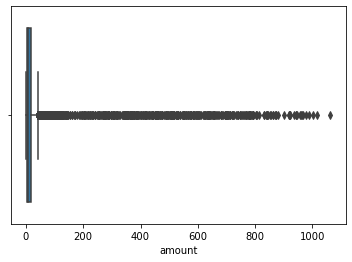

In [45]:
sns.boxplot(x=transcript.amount);

Transcript `amount` has odd distribution of amounts and there are lots of items considered as outliers based on tukey rule. We'll leave it as is for now.

**Final Cleanup**

In [46]:
portfolio = portfolio.drop(columns="hash_id")
portfolio.head()

,id,offer_type,channels,reward,difficulty,duration
0,1,bogo,"[email, mobile, social]",10,10,7
1,2,bogo,"[web, email, mobile, social]",10,10,5
2,3,informational,"[web, email, mobile]",0,0,4
3,4,bogo,"[web, email, mobile]",5,5,7
4,5,discount,"[web, email]",5,20,10


In [47]:
profile = profile.drop(columns="hash_id")
profile.head()

,id,gender,age,income,became_member_on
0,1,None,NaN,NaN,2017-02-12
1,2,F,55.0,112000.0,2017-07-15
2,3,None,NaN,NaN,2018-07-12
3,4,F,75.0,100000.0,2017-05-09
4,5,None,NaN,NaN,2017-08-04


## Export

Export the clean data to `csv`.

In [48]:
portfolio.to_csv("../data/processed/portfolio.csv", index=False)

In [49]:
profile.to_csv("../data/processed/profile.csv", index=False)

In [50]:
transcript.to_csv("../data/processed/transcript.csv", index=False)